# Algoritmo de Classificação de imagens

**Integrantes**: Cecília Fernandes, Charles Willian, Diego Ribeiro, Gabriel Campos

## Informações do projeto
- O problema resolvido neste projeto é o de Classificação, aqui treinamos uma CNN para identificar corretamente 5 tipos de flores diferentes.
- O algoritmo deve ter como saída 

## Executando localmente
- Execute o comando `pip install -r requirements.txt`
- Abra Jupyter pelo Anaconda
- Execute `Restart and Clear All`

## Passos de execução
1. Importações
2. a
3. a
4. a
5. Convolutionnal neural network (Rede neural convolucional)
6. Resultados
7. Data augmentation (Aumento de dados)

# 1. Importações

In [1]:
#
import numpy as np
import pandas as pd 
import random

# image
from PIL import Image

# visu
import matplotlib.pyplot as plt

# folder
import os
import glob

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 2. Carregando dados de imagem

Existem cinco categorias de flores. As imagens são carregadas em uma matriz numpy como matriz e as categorias associadas são carregadas em uma matriz independente.

In [2]:
categories = ["dandelion", "daisy", "sunflower", "tulip", "rose"]

Redimensionamos as imagens para que todas tenham a mesma largura e altura. Selecionamos a largura como a largura média de todas as imagens e a altura como a altura média de todas as imagens.

In [3]:
%%time
#
images_shapes = {"height": [], "width": []}
#
for cat in categories:
    filelist = glob.glob('./data/' + cat + '/*.jpg')
    for fname in filelist:
        images_shapes["height"].append(np.array(Image.open(fname)).shape[0])
        images_shapes["width"].append(np.array(Image.open(fname)).shape[1])

CPU times: user 17.2 s, sys: 1.67 s, total: 18.9 s
Wall time: 22.7 s


In [4]:
display("Average height: " + str(int(np.mean(images_shapes["height"]))))
display("Average width: " + str(int(np.mean(images_shapes["width"]))))

'Average height: 253'

'Average width: 338'

Devido à limitação de memória no Kaggle, não é possível manter 338 x 253. Vamos dividir a altura e a largura por dois.

In [5]:
im_width = int(338/2)
im_height = int(253/2)

In [6]:
display("Used height: " + str(im_height))
display("Used width: " + str(im_width))

'Used height: 126'

'Used width: 169'

Agora as imagens são carregadas e redimensionadas com uma largura de 169 e uma altura de 126 e armazenadas na matriz numpy:

In [7]:
data = []
target = []

In [8]:
%%time
for cat in categories:
    filelist = glob.glob('./data/' + cat + '/*.jpg')
    target.extend([cat for _ in filelist])
    data.extend([np.array(Image.open(fname).resize((im_width, im_height))) for fname in filelist])
#
data_array = np.stack(data, axis=0)

CPU times: user 13.2 s, sys: 746 ms, total: 13.9 s
Wall time: 14.9 s


Portanto, temos 4317 imagens de tensor de largura 169 e altura 126, cada pixel sendo definido por três cores R, G, B:

In [9]:
data_array.shape

(4317, 126, 169, 3)

Podemos verificar por imagens aleatórias se cada um deles tem o mesmo tamanho:

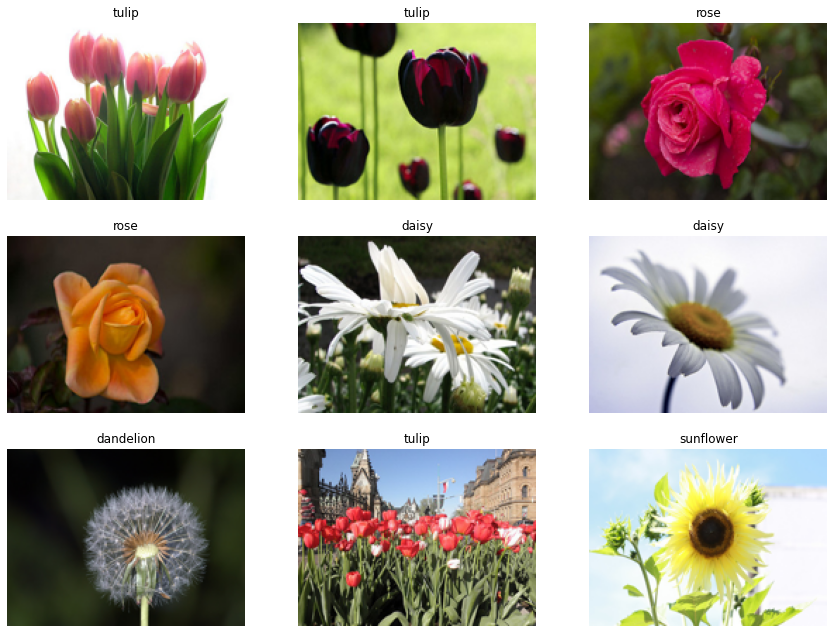

In [10]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, data_array.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off');
        ax.set_title(target[num_image])
        ax.imshow(data_array[num_image]);

# 3. Treinando a divisão do teste

Conforme indicado nas instruções, usamos a semente aleatória 43 e um tamanho de conjunto de teste de 20% do conjunto de dados. Além disso, usamos o parâmetro `stratify`set to` target` para que a repartição da classe seja mantida

In [11]:
pd.DataFrame(target).value_counts()/len(target)

dandelion    0.243688
tulip        0.227936
rose         0.181608
daisy        0.176975
sunflower    0.169794
dtype: float64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data_array, np.array(target), random_state=43, test_size=0.2, stratify=target)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3453, 126, 169, 3)
(864, 126, 169, 3)
(3453,)
(864,)


In [14]:
pd.DataFrame(y_train).value_counts()/len(y_train)

dandelion    0.243846
tulip        0.227918
rose         0.181581
daisy        0.176948
sunflower    0.169708
dtype: float64

In [15]:
pd.DataFrame(y_test).value_counts()/len(y_test)

dandelion    0.243056
tulip        0.228009
rose         0.181713
daisy        0.177083
sunflower    0.170139
dtype: float64

# 4. Preparando os dados

## Normalização
Para facilitar a convergência do algoritmo, é útil normalizar os dados. Veja aqui quais são os valores máximo e mínimo nos dados e normalize-os de acordo (as intensidades da imagem resultante devem estar entre 0 e 1).

In [16]:
print(X_train.max())
print(X_train.min())

255
0


In [17]:
X_test_norm = np.round((X_test/255), 3).copy()
X_train_norm = np.round((X_train/255), 3).copy()

Aqui, novamente, podemos verificar as imagens normalizadas aleatoriamente:

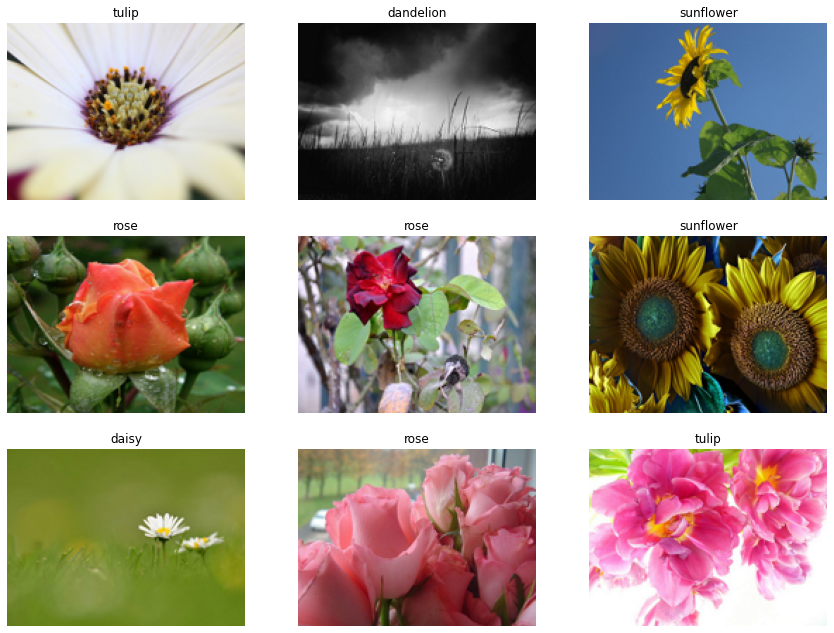

In [18]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, X_train_norm.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off');
        ax.set_title(y_train[num_image])
        ax.imshow(X_train_norm[num_image]);

## Codificação de destino

Aqui, convertemos os alvos. Primeiro, de string para valores numéricos, cada categoria se tornando um número inteiro, de 0 a 4 (já que existem cinco categorias de flores diferentes):

In [19]:
display(np.array(y_train).shape)
display(np.unique(y_train))
display(np.array(y_test).shape)
display(np.unique(y_test))

(3453,)

array(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'], dtype='<U9')

(864,)

array(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'], dtype='<U9')

Ajustando o codificador no conjunto de trem:

In [20]:
encoder = LabelEncoder().fit(y_train)

Aplicando no teste e no conjunto de teste:

In [21]:
y_train_cat = encoder.transform(y_train)
y_test_cat = encoder.transform(y_test)

E agora, convertemos o resultado em um alvo codificado de um ponto para que possam ser usados para treinar uma rede neural de classificação. Usamos `to_categorical` da biblioteca tensorflow:

In [22]:
y_train_oh = to_categorical(y_train_cat)
y_test_oh = to_categorical(y_test_cat)

In [23]:
pd.DataFrame(y_test_oh).head()

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0


# 5. Convolutionnal neural network (Rede neural convolucional)

Agora, vamos definir a Rede Neural Convolucional.

A CNN que é composta por:
- uma camada Conv2D com 32 filtros, um tamanho de kernel de (3, 3), a função de ativação relu, um preenchimento igual a `same` e a `input_shape` correta
- uma camada MaxPooling2D com um tamanho de (2, 2)
- uma camada Conv2D com 64 filtros, um tamanho de kernel de (3, 3), a função de ativação relu e um preenchimento igual a `same`
- uma camada MaxPooling2D com um tamanho de (2, 2)
- uma camada Conv2D com 128 filtros, um tamanho de kernel de (3, 3), a função de ativação relu e um preenchimento igual a `same`
- uma camada MaxPooling2D com um tamanho de (3, 3)
- uma camada achatada
- uma função densa com 120 neurônios com a função de ativação `relu`
- uma função densa com 60 neurônios com a função de ativação `relu`
- uma camada de dropout (com uma taxa de 0,5), para regularizar a rede
- uma função densa relacionada à sua tarefa: multiclassificação

In [24]:
def initialize_model():
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(im_height, im_width, 3), padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(60, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(5, activation='softmax'))

    return model

In [25]:
model = initialize_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 169, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 84, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 84, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 42, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 42, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 14, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 17920)             0

In [26]:
def compile_model(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics="accuracy")
    return model

Aqui é definido uma parada precoce após 5 épocas e defino o parâmetro `restore_best_weights` como` True` para que os pesos da melhor pontuação na métrica monitorada - aqui `val_accuracy` (precisão no conjunto de teste) - sejam restaurados quando o treinamento for interrompido. Dessa forma, o modelo tem a melhor precisão possível em dados não vistos.

In [27]:
model = initialize_model()
model = compile_model(model)
es = EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)

#model = initialize_model()
history = model.fit(X_train_norm, y_train_oh,
                    batch_size=16,
                    epochs=20,
                    validation_data=(X_test_norm, y_test_oh),
                    callbacks=[es])

Epoch 1/20
216/216 [==============================] - 57s 259ms/step - loss: 1.2670 - accuracy: 0.4579 - val_loss: 1.1013 - val_accuracy: 0.5312
Epoch 2/20
216/216 [==============================] - 57s 263ms/step - loss: 1.0054 - accuracy: 0.6001 - val_loss: 1.0808 - val_accuracy: 0.5903
Epoch 3/20
216/216 [==============================] - 53s 243ms/step - loss: 0.8435 - accuracy: 0.6727 - val_loss: 0.9862 - val_accuracy: 0.6169
Epoch 4/20
216/216 [==============================] - 58s 270ms/step - loss: 0.7140 - accuracy: 0.7266 - val_loss: 0.8936 - val_accuracy: 0.6644
Epoch 5/20
216/216 [==============================] - 55s 254ms/step - loss: 0.6125 - accuracy: 0.7785 - val_loss: 0.9538 - val_accuracy: 0.6551
Epoch 6/20
216/216 [==============================] - 55s 254ms/step - loss: 0.4484 - accuracy: 0.8361 - val_loss: 1.0178 - val_accuracy: 0.6493
Epoch 7/20
216/216 [==============================] - 50s 231ms/step - loss: 0.3158 - accuracy: 0.8844 - val_loss: 1.1282 - val_ac

# 6. Resultados

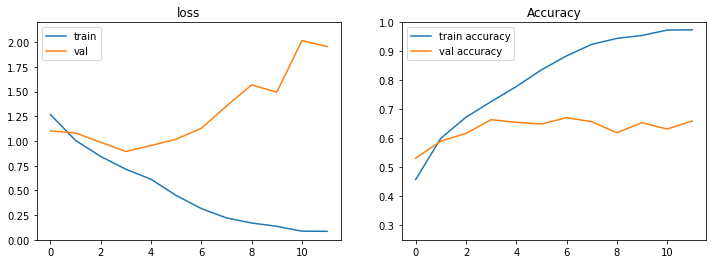

In [28]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

plot_history(history, title='', axs=None, exp_name="");

In [29]:
model.evaluate(X_test_norm, y_test_oh, verbose=0)

[1.1281975507736206, 0.6712962985038757]

Portanto, temos uma precisão de dados não vistos de quase 70%.

# 7. Data augmentation (Aumento de dados)

Tentamos melhorar a precisão do modelo usando o aumento de dados. Consiste em aplicar pouca transformação às imagens de entrada sem alterar seu rótulo.

Para isso, usamos `ImageDataGenerator` do tensorflow. Ele irá gerar imagens um pouco diferentes de uma imagem original, de modo que será como se o algoritmo estivesse treinando em mais dados

In [30]:
datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             rotation_range=10,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             zoom_range=(0.8, 1.2),) 
#
datagen.fit(X_train_norm)

A seguir, podemos olhar para a imagem original e a mesma imagem após sua pequena transformação:

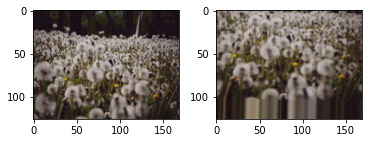

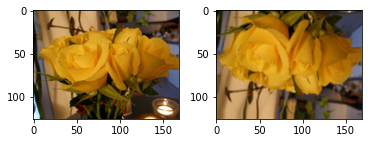

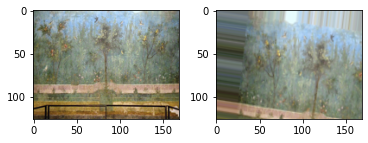

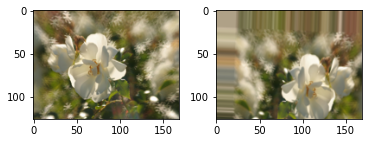

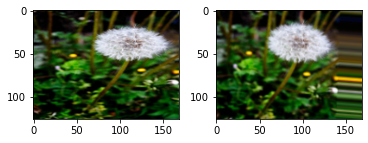

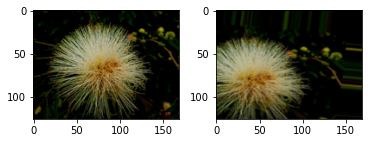

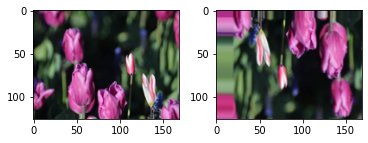

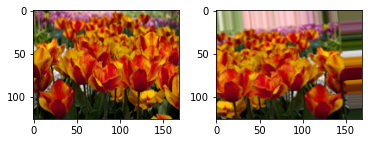

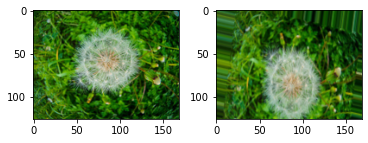

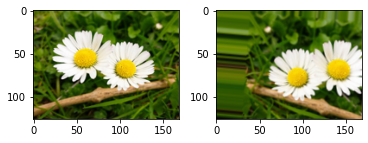

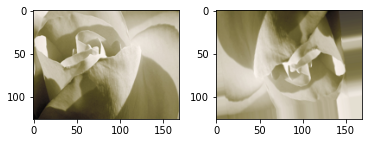

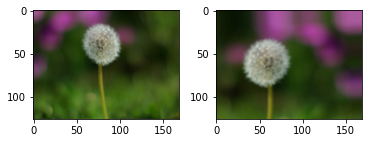

In [31]:
X_augmented = datagen.flow(X_train_norm, shuffle=False, batch_size=1)

for i, (raw_image, augmented_image) in enumerate(zip(X_train_norm, X_augmented)):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))
    ax1.imshow(raw_image)
    ax2.imshow(augmented_image[0])
    plt.show()
    
    if i > 10:
        break

Vamos treinar o modelo com esta melhoria:

In [ ]:
model_aug = initialize_model()
model_aug = compile_model(model_aug)
train_flow = datagen.flow(X_train_norm, y_train_oh, batch_size=32)
es = EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)

#model = initialize_model()
history_aug = model_aug.fit(train_flow,
                            epochs=20,
                            validation_data=(X_test_norm, y_test_oh),
                            callbacks=[es])

Epoch 1/20
108/108 [==============================] - 52s 479ms/step - loss: 1.3282 - accuracy: 0.4130 - val_loss: 1.1090 - val_accuracy: 0.5139
Epoch 2/20
108/108 [==============================] - 54s 493ms/step - loss: 1.1058 - accuracy: 0.5349 - val_loss: 1.0220 - val_accuracy: 0.5787
Epoch 3/20
 28/108 [======>.......................] - ETA: 36s - loss: 1.0229 - accuracy: 0.5935

In [ ]:
plot_history(history_aug, title='', axs=None, exp_name="");

In [ ]:
model_aug.evaluate(X_test_norm, y_test_oh, verbose=0)

Obtemos quase 10% mais precisão em dados não vistos em comparação com o modelo inicial!

In [ ]:
axs = plot_history(history_aug, exp_name='data_augmentation')
plot_history(history ,axs=axs, exp_name='baseline')
plt.show()